#Evalutaing Patient Readmission Risk


---

Group 10:

#1 - Business Problem Definition + Brief Description of data and its source

For reputations and financial reasons, hopistals tend to avoid readmissions.


Readmission is a healthcare metric that tracks patients who are re-admitted to a hospital within 30 days. This is gnerally avoided at hospitals' and patients' interests due to many complications, such as reduced coverage during readmissions from insurances like Medicare, which causes financial issues for hopitals and patients themselves (2012).


Hence, the business problem for US hospital here is that hospitals are losing money and credibility by having readmissions. We believe through analyzing the most prominent groups of readmitted patients, we can lower the readmission rates through preventions.

-----


Through the data from Clinical and Translational Research, Virginia Commonwealth University, we're able to explore 10 years (1999-2008) of clinical care data at 130 US hospitals and integrated delivery networks. This data set includes information of diabetic inpatient encounters ranges from 1 to 14 days, and if the encountered patients is readmitted (No, > 30 days, < 30days).


There are 55 variables and 100k instances, including some with missing values. The variables can generally be divided into four portions:

      - Demographic/basic information:
          - encounter_id
          - patient_nbr
          - race
          - gender
          - age
          - weight
      
      - Diagnosis:
          - admission_type_id
          - discharge_disposition_id
          - admission_source_id
          - time_in_hospital
          - payer_code
          - medical_specialty
          - num_lab_procedures
          - num_procedures
          - num_medications
          - number_outpatient
          - number_emergency
          - number_inpatient
          - diag_1
          - diag_2
          - diag_3
          - number_diagnoses
          - max_glu_serum
          - A1Cresult

       - Diabetic Medications:
          - metformin
          - repaglinide
          - nateglinide
          - chlorpropamide
          - glimepiride
          - acetohexamide
          - glipizide
          - glyburide
          - tolbutamide
          - pioglitazone
          - rosiglitazone
          - acarbose
          - miglitol
          - troglitazone
          - tolazamide
          - examide
          - citoglipton
          - insulin
          - glyburide-metformin
          - glipizide-metformin
          - glimepiride-pioglitazone
          - metformin-rosiglitazone
          - metformin-pioglitazone
          - change
          - diabetesMed
        
       - Readmission:
          - readmitted
  
By looking into how the demographic, diabetic diagnosis and diabetic medication histories can affect patients' readmission type, we hope to provide a business solution for hospitals to prevent key readmitted populations from premature discharges and more careful inpatient treatments upon diagnosis.

**Reference List:**
- *Hospital Readmissions*. (2012). Agency for Healthcare Research and Quality. Retrieved September 30, 2023 from https://www.ahrq.gov/topics/hospital-readmissions.html

##1.2 - Notes on how to use this notebook:


*   The full dataset was downloaded as assigned to the variable `df`
*   The cleaned version of the dataset, used in the initial exploratory analysis was assgined to `df_clean`



#2 - Loading the inital dataset and required libraries:


In [146]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [147]:
#Initial dataset:
df = pd.read_csv('https://raw.githubusercontent.com/eshentong/BA780-team10-project/main/readmission.csv')

#Create dataset copy to be cleaned
df_clean = df.copy()

#3 - Data Cleaning and Transformation:

When listing all the columns for the initial dataset, `df.info()` returns that are no null values in any of the columns. However, after the inital data cleaning and exploration of the data we found that many columns had a significant number of missing values, the were only marked with different types of symbols, the most common being `'?'`

In [148]:
#List of all initial variables:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

##`3.1- encounter_id`

In [149]:
#Set the encounter_id as the index for the dataset
df_clean.set_index('encounter_id', inplace=True)

##`3.1- patient_nbr`

In [150]:
df['patient_nbr'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 101766 entries, 0 to 101765
Series name: patient_nbr
Non-Null Count   Dtype
--------------   -----
101766 non-null  int64
dtypes: int64(1)
memory usage: 795.2 KB


##` 3.1- race`


---

* There are 2273 (2%) values missing
* Keep the variable, but replace `'?'` entries with `None`

In [151]:
df['race'].unique()

array(['Caucasian', 'AfricanAmerican', '?', 'Other', 'Asian', 'Hispanic'],
      dtype=object)

In [152]:
#Missing values:
len(df['race'][df['race'] == '?']), (len(df['race'][df['race'] == '?'])/len(df))*100

(2273, 2.2335554114340743)

In [153]:
#Replace the '?' result with None
race_map = {'?':None}

df_clean['race'].replace(race_map, inplace=True)

##`3.1- gender`


---

* There are only 3 (0.003%) values missing

In [154]:
df['gender'].unique()

array(['Female', 'Male', 'Unknown/Invalid'], dtype=object)

In [155]:
#Missing values:
len(df['gender'][df['gender'] == 'Unknown/Invalid']), (len(df['gender'][df['gender'] == 'Unknown/Invalid'])/len(df))*100

(3, 0.002947939390366134)

In [156]:
#Create map:
gender_map = {'Male':0, 'Female':1, 'Unknown/Invalid':None}

#Apply maeo:
df_clean['gender'].replace(gender_map, inplace=True)

##`3.1- age`


---

* No missing values
* Ready to use ?

In [157]:
df['age'].unique()

array(['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)', '[50-60)',
       '[60-70)', '[70-80)', '[80-90)', '[90-100)'], dtype=object)

In [158]:
df['age'].value_counts()

[70-80)     26068
[60-70)     22483
[50-60)     17256
[80-90)     17197
[40-50)      9685
[30-40)      3775
[90-100)     2793
[20-30)      1657
[10-20)       691
[0-10)        161
Name: age, dtype: int64

##`3.1- weight`


---
* There are 98,569 (97%) values missing
* Drop column due to high % of values missing


In [159]:
df['weight'].unique()

array(['?', '[75-100)', '[50-75)', '[0-25)', '[100-125)', '[25-50)',
       '[125-150)', '[175-200)', '[150-175)', '>200'], dtype=object)

In [160]:
#Missing values:
len(df['weight'][df['weight'] == '?']), (len(df['weight'][df['weight'] == '?'])/len(df))*100

(98569, 96.85847925633315)

In [161]:
#Drop weight due to large missing values
df_clean.drop(labels='weight', axis=1, inplace=True)

##`3.2- admission_type_id` PLACEHOLDER

##`3.2- discharge_disposition_id` PLACEHOLDER

##`3.2- admission_source_id` PLACEHOLDER

##`3.2- time_in_hospital`: Number of days between admission and discharge (int64)


---

*   min = 1; max = 14
*   No missing values
*   Ready to use

In [162]:
#Display all unique values for 'time_in_hospital':
df['time_in_hospital'].unique()

array([ 1,  3,  2,  4,  5, 13, 12,  9,  7, 10,  6, 11,  8, 14])

In [163]:
#Min, max, and sum of all null values:
df['time_in_hospital'].describe(), df['time_in_hospital'].isnull().sum()

(count    101766.000000
 mean          4.395987
 std           2.985108
 min           1.000000
 25%           2.000000
 50%           4.000000
 75%           6.000000
 max          14.000000
 Name: time_in_hospital, dtype: float64,
 0)

##`3.2- payer_code`: Unique identifier (key) that indicates who is paying (object). Includes self-pay


---


*   Missing values are noted as '?'
*   There are 40,256 missing values. (40%)
*   Drop the column due to the high % of missing values











In [164]:
df['payer_code'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 101766 entries, 0 to 101765
Series name: payer_code
Non-Null Count   Dtype 
--------------   ----- 
101766 non-null  object
dtypes: object(1)
memory usage: 795.2+ KB


In [165]:
#Display all unique values for 'time_in_hospital':
df['payer_code'].unique() #Note: '?' is a null value

array(['?', 'MC', 'MD', 'HM', 'UN', 'BC', 'SP', 'CP', 'SI', 'DM', 'CM',
       'CH', 'PO', 'WC', 'OT', 'OG', 'MP', 'FR'], dtype=object)

In [166]:
#Missing values:
len(df['payer_code'][df['payer_code'] == '?']), (len(df['payer_code'][df['payer_code'] == '?'])/len(df))*100

(40256, 39.5574160328597)

In [167]:
#Drop 'prayer_code' column
df_clean.drop('payer_code', axis=1, inplace=True)

##`3.2- medical_specialty`: specialty of the admitting doc (object)


---

*   Missing values are noted as '?'
*   There are 40,256 missing values. (49%)
*   Drop the column due to the high % of missing values



In [168]:
df['medical_specialty'].unique()

array(['Pediatrics-Endocrinology', '?', 'InternalMedicine',
       'Family/GeneralPractice', 'Cardiology', 'Surgery-General',
       'Orthopedics', 'Gastroenterology',
       'Surgery-Cardiovascular/Thoracic', 'Nephrology',
       'Orthopedics-Reconstructive', 'Psychiatry', 'Emergency/Trauma',
       'Pulmonology', 'Surgery-Neuro',
       'Obsterics&Gynecology-GynecologicOnco', 'ObstetricsandGynecology',
       'Pediatrics', 'Hematology/Oncology', 'Otolaryngology',
       'Surgery-Colon&Rectal', 'Pediatrics-CriticalCare', 'Endocrinology',
       'Urology', 'Psychiatry-Child/Adolescent', 'Pediatrics-Pulmonology',
       'Neurology', 'Anesthesiology-Pediatric', 'Radiology',
       'Pediatrics-Hematology-Oncology', 'Psychology', 'Podiatry',
       'Gynecology', 'Oncology', 'Pediatrics-Neurology',
       'Surgery-Plastic', 'Surgery-Thoracic',
       'Surgery-PlasticwithinHeadandNeck', 'Ophthalmology',
       'Surgery-Pediatric', 'Pediatrics-EmergencyMedicine',
       'PhysicalMedicineandRe

In [169]:
#Missing values:
len(df['medical_specialty'][df['medical_specialty'] == '?']), len(df['medical_specialty'][df['medical_specialty'] == '?'])/len(df)

(49949, 0.49082208203132677)

In [170]:
#Drop 'medical_specialty' column:
df_clean.drop('medical_specialty', axis=1, inplace=True)

##`3.2- num_lab_procedures`: Number of lab tests performed during stay (int64)


---


*   min = 1; max = 132
*   No missing values
*   Ready to use




In [171]:
df['num_lab_procedures'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 101766 entries, 0 to 101765
Series name: num_lab_procedures
Non-Null Count   Dtype
--------------   -----
101766 non-null  int64
dtypes: int64(1)
memory usage: 795.2 KB


In [172]:
df['num_lab_procedures'].unique()

array([ 41,  59,  11,  44,  51,  31,  70,  73,  68,  33,  47,  62,  60,
        55,  49,  75,  45,  29,  35,  42,  66,  36,  19,  64,  25,  53,
        52,  87,  27,  37,  46,  28,  48,  72,  10,   2,  65,  67,  40,
        54,  58,  57,  43,  32,  83,  34,  39,  69,  38,  56,  22,  96,
        78,  61,  88,  50,   1,  18,  82,   9,  63,  24,  71,  77,  81,
        76,  90,  93,   3, 103,  13,  80,  85,  16,  15,  12,  30,  23,
        17,  21,  79,  26,   5,  95,  97,  84,  14,  74, 105,  86,  98,
        20,   6,  94,   8, 102, 100,   7,  89,  91,  92,   4, 101,  99,
       114, 113, 111, 129, 107, 108, 106, 104, 109, 120, 132, 121, 126,
       118])

In [173]:
df['num_lab_procedures'].describe(), 'Missing values: ' + str(df['num_lab_procedures'].isnull().sum())

(count    101766.000000
 mean         43.095641
 std          19.674362
 min           1.000000
 25%          31.000000
 50%          44.000000
 75%          57.000000
 max         132.000000
 Name: num_lab_procedures, dtype: float64,
 'Missing values: 0')

##`3.2- num_medications`: Number of distinct generic meds given during stay (int64)


---



*   min = 1; max = 81
*   No missing values
*   Ready to used






In [174]:
df['num_medications'].unique()

array([ 1, 18, 13, 16,  8, 21, 12, 28, 17, 11, 15, 31,  2, 23, 19,  7, 20,
       14, 10, 22,  9, 27, 25,  4, 32,  6, 30, 26, 24, 33,  5, 39,  3, 29,
       61, 40, 46, 41, 36, 34, 35, 50, 43, 42, 37, 51, 38, 45, 54, 52, 49,
       62, 55, 47, 44, 53, 48, 57, 59, 56, 60, 63, 58, 70, 67, 64, 69, 65,
       68, 66, 81, 79, 75, 72, 74])

In [175]:
df['num_medications'].describe(), 'Missing values: ' + str(df['num_medications'].isnull().sum())

(count    101766.000000
 mean         16.021844
 std           8.127566
 min           1.000000
 25%          10.000000
 50%          15.000000
 75%          20.000000
 max          81.000000
 Name: num_medications, dtype: float64,
 'Missing values: 0')

##3.2- `number_outpatient`: Number of outpatient(service/treatment that does not require hospitalization) visits the patient had in the year preceding the stay (int64)


---



*   min = 0; max = 42
*   No missing values
*   Ready to use







In [176]:
df['number_outpatient'].unique()

array([ 0,  2,  1,  5,  7,  9,  3,  8,  4, 12, 11,  6, 20, 15, 10, 13, 14,
       16, 21, 35, 17, 29, 36, 18, 19, 27, 22, 24, 42, 39, 34, 26, 33, 25,
       23, 28, 37, 38, 40])

In [177]:
df['number_outpatient'].describe(), 'Missing values: ' + str(df['number_outpatient'].isnull().sum())

(count    101766.000000
 mean          0.369357
 std           1.267265
 min           0.000000
 25%           0.000000
 50%           0.000000
 75%           0.000000
 max          42.000000
 Name: number_outpatient, dtype: float64,
 'Missing values: 0')

##`3.2- number_emergency`: Number of emergency visits of the patient preceding the stay (int64)


---



*   min = 0; max = 76
*   No missing values
*   Ready to use!




In [178]:
df['number_emergency'].unique()

array([ 0,  1,  2,  4,  3,  9,  5,  7,  6,  8, 22, 25, 10, 13, 42, 16, 11,
       28, 15, 14, 18, 12, 21, 20, 19, 46, 76, 37, 64, 63, 54, 24, 29])

In [179]:
df['number_emergency'].describe(), 'Missing values: ' + str(df['number_emergency'].isnull().sum())

(count    101766.000000
 mean          0.197836
 std           0.930472
 min           0.000000
 25%           0.000000
 50%           0.000000
 75%           0.000000
 max          76.000000
 Name: number_emergency, dtype: float64,
 'Missing values: 0')

##`3.2- number_inpatient`: Number of inpatient visits (required hospitalization) in the year preceding the stay (int64)


---



*   min = 0; max = 21
*   No missing values
*   Ready to use!







In [180]:
df['number_inpatient'].unique()

array([ 0,  1,  2,  3,  6,  5,  4,  7,  8,  9, 15, 10, 11, 14, 12, 13, 17,
       16, 21, 18, 19])

In [181]:
df['number_inpatient'].describe(), 'Missing values: ' + str(df['number_inpatient'].isnull().sum())

(count    101766.000000
 mean          0.635566
 std           1.262863
 min           0.000000
 25%           0.000000
 50%           0.000000
 75%           1.000000
 max          21.000000
 Name: number_inpatient, dtype: float64,
 'Missing values: 0')

##

##`3.2- diag_1, diag_2, diag_3`: the primary and two secondary diagnosis of each patient. Due to the high number of possible diagnosis, we first group them into higher level diseases groups. (ADD SOURCE OF GROUPING METHOD)


---



In [182]:
#Group diagnosis into higher level groups:

# http://www.icd9data.com/2008/Volume1/default.htm
def diag_to_cat(value):
    if 'V' in value:
        return 'Supplementary Classification Of Factors Influencing Health Status And Contact With Health Services'
    elif 'E' in value:
        return 'Supplementary Classification Of External Causes Of Injury And Poisoning'
    elif '?' in value:
        return None
    value = float(value)
    value = int(value)
    if value in range(1, 140):
        return 'Infectious And Parasitic Diseases'
    elif value in range(140, 240):
        return 'Neoplasms'
    elif value in range(240, 280):
        return 'Endocrine, Nutritional And Metabolic Diseases, And Immunity Disorders'
    elif value in range(280, 290):
        return 'Diseases Of The Blood And Blood-Forming Organs'
    elif value in range(290, 320):
        return 'Mental Disorders'
    elif value in range(320, 390):
        return 'Diseases Of The Nervous System And Sense Organs'
    elif value in range(390, 460):
        return 'Diseases Of The Circulatory System'
    elif value in range(460, 520):
        return 'Diseases Of The Respiratory System'
    elif value in range(520, 580):
        return 'Diseases Of The Digestive System'
    elif value in range(580, 630):
        return 'Diseases Of The Genitourinary System'
    elif value in range(630, 680):
        return 'Complications Of Pregnancy, Childbirth, And The Puerperium'
    elif value in range(680, 710):
        return 'Diseases Of The Skin And Subcutaneous Tissue'
    elif value in range(710, 740):
        return 'Diseases Of The Musculoskeletal System And Connective Tissue'
    elif value in range(740, 760):
        return 'Congential Anomalies'
    elif value in range(760, 780):
        return 'Certain Conditions Originating In The Perinatal Period'
    elif value in range(780, 800):
        return 'Symptoms, Signs, And Ill-Defined Conditions'
    elif value in range(800, 1000):
        return 'Injury And Poisoning'
    else:
        return 'Not in Dictionary'



In [183]:
#Create new columns for the higher level disease groups:
df_clean['diag_1_cat'] = df_clean['diag_1'].apply(diag_to_cat)
df_clean['diag_2_cat'] = df_clean['diag_2'].apply(diag_to_cat)
df_clean['diag_3_cat'] = df_clean['diag_3'].apply(diag_to_cat)

#Drop old columns:
df_clean = df_clean.drop(columns= ['diag_1', 'diag_2', 'diag_3'])


##`3.2- number_diagnoses`: PLACEHOLDER


---



In [184]:
df['number_diagnoses'].unique()

array([ 1,  9,  6,  7,  5,  8,  3,  4,  2, 16, 12, 13, 15, 10, 11, 14])

In [185]:
df['number_diagnoses'].describe(), 'Missing values: ' + str(df['number_diagnoses'].isnull().sum())

(count    101766.000000
 mean          7.422607
 std           1.933600
 min           1.000000
 25%           6.000000
 50%           8.000000
 75%           9.000000
 max          16.000000
 Name: number_diagnoses, dtype: float64,
 'Missing values: 0')

##`3.2- max_glu_serum`, `A1Cresult`: PLACEHOLDER (What did we decide for all the null values with here?)


---



In [186]:
df['max_glu_serum'].unique(), df['A1Cresult'].unique()

(array(['None', '>300', 'Norm', '>200'], dtype=object),
 array(['None', '>7', '>8', 'Norm'], dtype=object))

Mapping lab results into normal (0), abnormal (1), and null (None):

In [187]:
#Create map:
glu_serum_test_mapping = {'>300':1, '>200':1, 'Norm':0, 'None':None}
A1C_test_mapping = {'>8':1, '>7':1, 'Norm':0, 'None':None}

#Replace old values with map:
df_clean['max_glu_serum'] = df_clean['max_glu_serum'].replace(glu_serum_test_mapping)
df_clean['A1Cresult'] = df_clean['A1Cresult'].replace(A1C_test_mapping)

df_clean['max_glu_serum'].isnull().sum(), df_clean['A1Cresult'].isnull().sum()

(96420, 84748)

## 3.3- Prescriptions : `metformin`, `repaglinide`, `nateglinide`, `chlorpropamide`, `glimepiride`, `acetohexamide`, `glipizide`, `glyburide`, `tolbutamide`, `pioglitazone`, `rosiglitazone`, `acarbose`, `miglitol`, `troglitazone`, `tolazamide`, `examide`, `citoglipton`, `insulin`, `glyburide-metformin`, `glipizide-metformin`, `glimepiride-pioglitazone`, `metformin-rosiglitazone`, `metformin-pioglitazone`


---
* For the prescriptions in the dataset, we applied a similar cleaning strategy. All mediactions had no missing values, and the following unique values: `'No'`, `'Steady'`, `'Down'`, `'Up'`. For our analysis, we decided to convert 'No' values into `0`, and `'Steady'`, `'Down'`, and `'Up'` into` 1`

* To concentrate on the most frequently prescribed medications, we opted to exclude columns representing medications taken by less than 0.1% of the patients.

* The folliwing medicstions did not meet this criteria and were dropped: PLACEHOLDER


In [188]:
#Mapping Prescriptions to yes(1) or no(0) prescription:
prescription_mapping = {'Down':1, 'Up':1, 'Steady':1, 'No':0}

#Create list of columns with the prescription to be transformed:
prescription_list = list(df.loc[:,'metformin': 'metformin-pioglitazone'].columns)

#Apply map:
for prescription in prescription_list:

  df_clean[prescription] = df_clean[prescription].replace(prescription_mapping)

In [189]:
#Calculate the % of patients taking each medication:

#Start a list of lists to hold the medication name and its % use
med_avg = [[],[]]

#Calculate % use and append to list
for i in df_clean[prescription_list].columns:

  med_avg[0].append(i)
  med_avg[1].append((df_clean[i].sum()/len(df_clean[i])))

med_avg

#Create a better format for the output
print('Prescriptions and their % use in the dataset:', '\n')
for i, percentage in zip(med_avg[1], df_clean[prescription_list].columns ):
    print(f'{percentage}: {round(i*100,3)}%')

Prescriptions and their % use in the dataset: 

metformin: 19.641%
repaglinide: 1.512%
nateglinide: 0.691%
chlorpropamide: 0.085%
glimepiride: 5.101%
acetohexamide: 0.001%
glipizide: 12.466%
glyburide: 10.465%
tolbutamide: 0.023%
pioglitazone: 7.201%
rosiglitazone: 6.255%
acarbose: 0.303%
miglitol: 0.037%
troglitazone: 0.003%
tolazamide: 0.038%
examide: 0.0%
citoglipton: 0.0%
insulin: 53.439%
glyburide-metformin: 0.694%
glipizide-metformin: 0.013%
glimepiride-pioglitazone: 0.001%
metformin-rosiglitazone: 0.002%
metformin-pioglitazone: 0.001%


In [190]:
#Drop columns with less than 0.1% use:

med_threshold = 0.001
med_col_drop = []

for n in range(len(prescription_list)):

  if med_avg[1][n] < med_threshold:

    med_col_drop.append(med_avg[0][n])

df_clean.drop(labels=med_col_drop, axis=1, inplace=True)



In [191]:
df_clean.columns

Index(['patient_nbr', 'race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient',
       'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'glimepiride', 'glipizide', 'glyburide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'insulin',
       'glyburide-metformin', 'change', 'diabetesMed', 'readmitted',
       'diag_1_cat', 'diag_2_cat', 'diag_3_cat'],
      dtype='object')

##`3.3- change`: PLACEHOLDER (do we know what this is or do we drop it?)

In [192]:
df_clean.columns

Index(['patient_nbr', 'race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient',
       'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'glimepiride', 'glipizide', 'glyburide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'insulin',
       'glyburide-metformin', 'change', 'diabetesMed', 'readmitted',
       'diag_1_cat', 'diag_2_cat', 'diag_3_cat'],
      dtype='object')

##`3.3- diabetesMed`: indicates if there was any diabetic mediation prescribed.


---

* Unique values for this variables were 'Yes' and 'No'. For our analysis we transformed `'Yes'` to `1`, and `'No'` to `0`
* No missing values

In [193]:
df['diabetesMed'].unique()

array(['No', 'Yes'], dtype=object)

In [194]:
#Create map:
diabetesMed_mapping = {'Yes':1, 'No':0}

#Apply map:
df_clean['diabetesMed'] = df_clean['diabetesMed'].replace(diabetesMed_mapping)

##`3.4 - readmitted`: PLACEHOLDER

In [195]:
df['readmitted'].unique()

array(['NO', '>30', '<30'], dtype=object)

In [196]:
#Create map:
readmitted_mapping = {'NO': 0, '>30': 0, '<30': 1}

#Apply map:
df_clean['readmitted'] = df_clean['readmitted'].replace(readmitted_mapping)

df_clean.head()

,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,...,rosiglitazone,acarbose,insulin,glyburide-metformin,change,diabetesMed,readmitted,diag_1_cat,diag_2_cat,diag_3_cat
encounter_id,,,,,,,,,,,,,,,,,,,,,
2278392,8222157,Caucasian,1.0,[0-10),6,25,1,1,41,0,...,0,0,0,0,No,0,0,"Endocrine, Nutritional And Metabolic Diseases,...",None,None
149190,55629189,Caucasian,1.0,[10-20),1,1,7,3,59,0,...,0,0,1,0,Ch,1,0,"Endocrine, Nutritional And Metabolic Diseases,...","Endocrine, Nutritional And Metabolic Diseases,...","Endocrine, Nutritional And Metabolic Diseases,..."
64410,86047875,AfricanAmerican,1.0,[20-30),1,1,7,2,11,5,...,0,0,0,0,No,1,0,"Complications Of Pregnancy, Childbirth, And Th...","Endocrine, Nutritional And Metabolic Diseases,...",Supplementary Classification Of Factors Influe...
500364,82442376,Caucasian,0.0,[30-40),1,1,7,2,44,1,...,0,0,1,0,Ch,1,0,Infectious And Parasitic Diseases,"Endocrine, Nutritional And Metabolic Diseases,...",Diseases Of The Circulatory System
16680,42519267,Caucasian,0.0,[40-50),1,1,7,1,51,0,...,0,0,1,0,Ch,1,0,Neoplasms,Neoplasms,"Endocrine, Nutritional And Metabolic Diseases,..."


#4 - Data Exploration:


*   (FOR TEAM) From this section ownards remember to use the `df_clean` to generate insights, graphs ✌



4.1 - How does the average A1Cresult, a test for diabetes diagnosis, varies with age and by gender?


---
In the graph below, we see the average A1C abnormal values by age, where 0 indicates a normal result and 1 indicates that the patient has diabetes. The different colored bar also indicate the differences between Male (0) and Female (1).

It is interesting to note how the A1C average of abnormal results actually goes down with age. While counter intuitive, one possible reason is that older patient might be more likely to be using and have a higher adherence to medication to control their blood sugar, leading to less abnormal A1C results. Another possible reason for the high average A1C result in the earlist age group, 0-10, is that children might be born with type-I diabetes, which could result in high A1C levels until it is properly treated.

It is also noteworthy that Female patients seem to have better A1C readings in almost all age ranges.


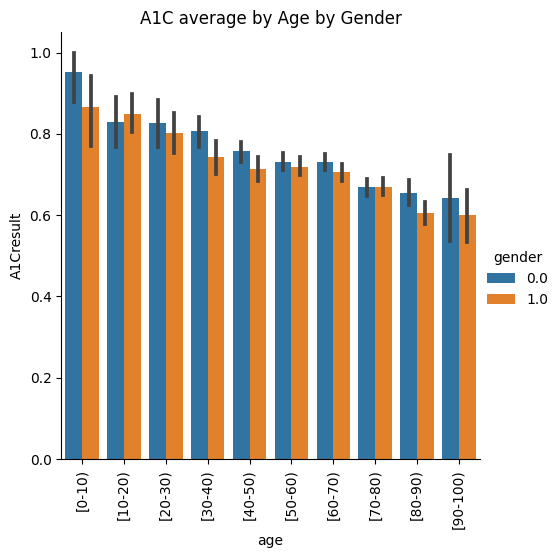

In [197]:
#Select all observations for which we have A1C test results:
a1c_age_race_df = df_clean[df_clean['A1Cresult'].notnull()]

sns.catplot(data=a1c_age_race_df, x='age', y='A1Cresult', kind='bar', hue='gender', order=['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)', '[50-60)',
       '[60-70)', '[70-80)', '[80-90)', '[90-100)'], width=0.8)
plt.xticks(rotation=90)
plt.title('A1C average by Age by Gender')
plt.show()
